In [1]:
# %%px
use_dolfinx = True
nprocs = 2

### colab

In [2]:
# %%px
import os
colab = os.getcwd() == "/content"


In [3]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


In [5]:
# %%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

--2025-05-08 14:36:51--  https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4339 (4.2K) [application/x-sh]
Saving to: ‘/tmp/fenicsx-install.sh’

/tmp/fenicsx-instal 100%[===================>]   4.24K  --.-KB/s    in 0s      

2025-05-08 14:36:51 (80.5 MB/s) - ‘/tmp/fenicsx-install.sh’ saved [4339/4339]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICSX_INSTALLED=/usr/local/share/fem-on-colab/fenicsx.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenicsx.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/a51d633e/release

### parallel

In [6]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   96
  On-line CPU(s) list:    0-95
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   24
    Socket(s):            2
    Stepping:             3
    BogoMIPS:             4000.44
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervis

In [7]:
## Parallel programming imports
import ipyparallel as ipp
from mpi4py import MPI

In [8]:
os.environ["OMPI_ALLOW_RUN_AS_ROOT"] = "1"
os.environ["OMPI_ALLOW_RUN_AS_ROOT_CONFIRM"] = "1"
os.environ["OMP_NUM_THREADS"] = "48"     # un rank su 48 core (un socket)
os.environ["MKL_NUM_THREADS"] = "48"     # se usi MKL per algebra lineare

cluster = ipp.Cluster(
    engines="mpi",
    n=nprocs,
    engine_launcher_args={
        "mpirun_args": [
            "--allow-run-as-root",         # già confermato con variabili ma non guasta
            # "--use-hwthread-cpus"          # 1: conta gli hw threads come slot
            "--bind-to", "socket",
            "--map-by", "socket",
            "--report-bindings"
            # oppure: "--map-by", ":OVERSUBSCRIBE"
        ]
    }
)
rc = cluster.start_and_connect_sync()
print("Engine MPI avviati correttamente!")


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

Engine MPI avviati correttamente!


### dolfinx

In [9]:
%%px
use_dolfinx = True

In [10]:
%%px
import os
colab = os.getcwd() == "/content"

In [11]:
%%px
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

### import

In [12]:
%%px
from __future__ import print_function


In [13]:
!pip install pyDOE

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyDOE: filename=pydoe-0.3.8-py3-none-any.whl size=18223 sha256=f9394a8b9ce47eafcbb46a0a39870c9508c8b9fd74663765ea41e04212b7d32d
  Stored in directory: /root/.cache/pip/wheels/84/20/8c/8bd43ba42b0b6d39ace1219d6da1576e0dac81b12265c4762e
Successfully built pyDOE


In [14]:
%%px
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()
import pyDOE

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:1] WARNING:py.warnings:/tmp/ipykernel_3692/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



[stderr:0] WARNING:py.warnings:/tmp/ipykernel_3691/1710578147.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook



In [15]:
%%px
from IPython.display import clear_output as clc

plt.style.use("default")


In [16]:
%%px
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [17]:
%%px
from scipy.interpolate import RBFInterpolator

In [18]:
%%px
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [19]:
%%px
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [20]:
%%px
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [21]:
%%px
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED")

# Parameters

In [22]:
%%px

# Airfoil parameters
chord = 1  # Adjust as needed
# Aoa = 20

# Domain parameters
mesh_type = "cmesh"
if mesh_type=="circle":
    R=15 # per O-mesh
    x_le, y_le = 0.0, 0.0
elif mesh_type=="rectangle":
    L = 20
    H = 10
    x_le, y_le = 0.25 * L, 0.5 * H
elif mesh_type=="cmesh":
    L, H = 10, 10 #L  (L distanza da le a xmax, H altezza totale)
    x_le, y_le = 0.0, 0.0
else:
    raise ValueError("Invalid mesh type.")

# Utilities

### airfoil utilities

In [23]:
%%px
import numpy as np

def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le=0.0, y_le=0.0, alpha_deg=0.0, sharp=True):
    """
    Genera un profilo alare tipo NACA-like con rotazione secondo l’angolo di attacco.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)
        x_le: coordinata x del leading edge
        y_le: coordinata y del leading edge
        alpha_deg: angolo di attacco in gradi (rotazione anti-oraria)

    Returns:
        coords: array Nx2 con le coordinate dell'airfoil ruotato
    """

    # Se l'airfoil è sharp, il numero di punti è pari (punto 0 non è ripetuto alla fine)

    # Distribuzione dei punti (più densi verso il bordo d'attacco)
    x = ((1 - np.cos(np.linspace(0, 1, n_points//2+1) * np.pi)) / 2)**0.7
    # x = np.linspace(0, 1, int(np.ceil(n_points / 2)))

    # Curva di camber e sua derivata
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore
    alpha4 = 0.1036 if sharp else 0.1015
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - alpha4*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione delle coordinate
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:-1]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:-1]])
    # x_coords = np.concatenate([x_upper[::-1][5:], x_lower[1:][:-5], np.array([x_upper[::-1][5:][0]]*5)])
    # y_coords = np.concatenate([y_upper[::-1][5:], y_lower[1:][:-5], np.linspace(y_lower[1:][:-5][-1], y_upper[::-1][5:][0], 5)])
    # x_coords = np.array(x_coords.tolist() + [x_coords[0].item()])
    # y_coords = np.array(y_coords.tolist() + [y_coords[0].item()])

    assert(len(x_coords)==n_points)

    # Traslazione iniziale
    x_coords += x_le
    y_coords += y_le

    # Rotazione dell'airfoil attorno al punto (x_le, y_le)
    alpha_rad = np.radians(alpha_deg)
    cos_a, sin_a = np.cos(alpha_rad), np.sin(alpha_rad)

    x_rot = x_le + (x_coords - x_le) * cos_a - (y_coords - y_le) * sin_a
    y_rot = y_le + (x_coords - x_le) * sin_a + (y_coords - y_le) * cos_a

    return np.stack([x_rot, y_rot], axis=1)


def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [24]:
%%px
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    biggest_x_idx = np.argmax(ordered_points[:, 0]) #useful for airfoil

    return np.concatenate([ordered_points[biggest_x_idx:], ordered_points[:biggest_x_idx]])

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

###mesh utilities

In [25]:
%%px
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05, mesh_type="rectangle"):

    assert(len(airfoil_coords)==len(new_airfoil_coords))

    N_points = airfoil_coords.shape[0]
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    if mesh_type=="rectangle":
        wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
        wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
        wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
        wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

        control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)
    elif mesh_type=="circle":
        theta = np.arange(0, 2*np.pi, step_size)
        farfield_points = R * np.concatenate((np.cos(theta).reshape(-1, 1), np.sin(theta).reshape(-1, 1)), 1)

        control_points = np.concatenate((airfoil_control_points, farfield_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros(farfield_points)), axis = 0)

    elif mesh_type=="cmesh":
        theta = np.arange(0, 2*np.pi, step_size)
        farfield_points = R * np.concatenate((np.cos(theta).reshape(-1, 1), np.sin(theta).reshape(-1, 1)), 1)

        control_points = np.concatenate((airfoil_control_points, farfield_points), axis = 0)
        displacements = np.concatenate((airfoil_displacements, np.zeros(farfield_points)), axis = 0)

    return control_points, displacements



In [26]:
%%px
def get_global_coords(mesh):

    if MPI.COMM_WORLD.size==1:
        return mesh.geometry.x

    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q_vec = functionspace(mesh, s_cg1)

    im = Q_vec.dofmap.index_map
    N = im.size_global

    # Alloco un array di coordinate (N, 2) su rank 0
    coords_global = np.zeros((N, 3))

    # Su ogni rank preparo
    coords_local = Q_vec.tabulate_dof_coordinates()     # (size_local, 2)
    local_idxs   = np.arange(im.size_local, dtype=int)
    owned        = np.setdiff1d(local_idxs, im.ghosts)
    global_idxs  = im.local_to_global(owned)           # lunghezza = n_owned
    coords_owned = coords_local[owned]

    # Gather di (coords_owned, global_idxs) su rank 0
    gathered_coords = comm.gather(coords_owned,   root=0)
    gathered_globs  = comm.gather(global_idxs,    root=0)

    if rank==0:
        # Riempi il coords_global usando i global indices
        for pts, gl in zip(gathered_coords, gathered_globs):
            coords_global[gl, :] = pts

        return coords_global
    else:
        return None

    # np.savez("data/pinball_data.npz", naca0012_airfoil_coords = pinball_coords, naca0012_coords = coords_global)

In [27]:
%%px
def get_boundary_idxs(mesh, ft, marker):
    boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    vertices = dolfinx.mesh.compute_incident_entities(mesh.topology, ft.find(marker), mesh.topology.dim-1, 0)
    idxs = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, vertices, False)

    return idxs[:, 0].tolist()

In [28]:
%%px
def get_control_points_and_displacements2(mesh, ft, new_obstacle_coords, obstacle_marker, boundary_markers: list, obstacle_coords=None, each=4):

    if obstacle_coords is None:
        obstacle_indices = get_boundary_idxs(mesh, ft, obstacle_marker)
        obstacle_coords = order_polygon(mesh.geometry.x[obstacle_indices])[:, :2]
    else:
        obstacle_coords = order_polygon(obstacle_coords)
    new_obstacle_coords = order_polygon(new_obstacle_coords)

    boundary_indices = []
    for marker in boundary_markers:
        boundary_indices += get_boundary_idxs(mesh, ft, marker)
    boundary_indices = np.array(boundary_indices)
    boundary_coords = order_polygon(mesh.geometry.x[boundary_indices])[:, :2]

    assert(len(obstacle_coords)==len(new_obstacle_coords))

    # Control points
    obstacle_control_points = obstacle_coords[::each] # + np.array([x_le, y_le])
    new_obstacle_control_points = new_obstacle_coords[::each] # + np.array([x_le, y_le])
    boundary_control_points = boundary_coords[::each]
    control_points = np.concatenate((obstacle_control_points, boundary_control_points), axis = 0)

    # Displacements
    obstacle_displacements = np.array(new_obstacle_control_points - obstacle_control_points)
    boundary_displacements = np.zeros_like(boundary_control_points)
    displacements = np.concatenate((obstacle_displacements, boundary_displacements), axis = 0)

    return control_points, displacements

In [29]:
%%px
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [30]:
%%px
def smooth_mesh(mesh, iterations=10, omega=0.3, fix_boundary=True):
    """
    Applica Laplacian smoothing alla mesh DolfinX in-place.

    Parametri:
        mesh         : dolfinx.mesh.Mesh
        iterations   : numero di passi di smoothing
        omega        : fattore di rilassamento (0<omega<1)
        fix_boundary : se True, i nodi su facce esterne non vengono mossi
    """
    # Copia delle coordinate
    coords = mesh.geometry.x.copy()

    # Topologia necessaria
    topo = mesh.topology
    topo.create_connectivity(0, topo.dim)
    topo.create_connectivity(topo.dim, 0)

    # Connessioni vertice->cella e cella->vertice
    v2c = topo.connectivity(0, topo.dim)
    c2v = topo.connectivity(topo.dim, 0)

    # Calcola facce di bordo e vertici di bordo
    boundary_vertices = set()
    if fix_boundary:
        # Crea connettività faccia->vertice
        topo.create_connectivity(topo.dim - 1, 0)
        # Indici delle facet esterne
        boundary_facets = dolfinx.mesh.exterior_facet_indices(topo)
        # Vertici incidenti a queste facet
        bv = dolfinx.mesh.compute_incident_entities(topo, boundary_facets, topo.dim - 1, 0)
        # Mappa C++ -> geometria (necessario per assicurare ordinamento corretto)
        vertex_to_geometry = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, bv, False)
        boundary_vertices = set(bv)

    # Loop di smoothing
    for _ in range(iterations):
        print(f"Smoothing iter n°{_+1}")
        new_coords = coords.copy()
        for vid in range(coords.shape[0]):
            if vid in boundary_vertices:
                continue
            # celle attorno al vertice
            cell_ids = v2c.links(vid)
            # insieme vertici vicini
            neigh_vs = set()
            for cid in cell_ids:
                neigh_vs.update(c2v.links(cid))
            neigh_vs.discard(vid)
            if not neigh_vs:
                continue
            # baricentro
            centroid = coords[list(neigh_vs)].mean(axis=0)
            # spostamento
            new_coords[vid] += omega * (centroid - coords[vid])
        coords = new_coords

    # Scrivi nuove coordinate
    mesh.geometry.x[:] = coords
    return mesh

In [31]:
%%px
def interpolate_mesh(mesh, control_points, displacements,
                           smooth=False, smooth_iters=15, smooth_omega=0.3):
    # 1) Interpolazione RBF
    from dolfinx.fem import FunctionSpace
    import ufl

    # usa Lagrange di grado 1
    V = functionspace(mesh, element("Lagrange", mesh.topology.cell_name(), 1))
    coords = V.tabulate_dof_coordinates()  # array N x gdim

    # RBF
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0)
    disp = rbf(coords[:, :2])
    mesh.geometry.x[:, :2] = coords[:, :2] + disp

    # 2) smoothing Laplaciano
    if smooth:
        mesh = smooth_mesh(mesh,
                          iterations=smooth_iters,
                          omega=smooth_omega,
                          fix_boundary=True)
    return mesh

### dolfinx utilities

#### bcs

In [32]:
%%px
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            self.U_max
        )
        values[1] = (
            0
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha, bcwalls="freeslip",mesh_type="rectangle"):
    """
    Boundary conditions for velocity and pressure:
      - freeslip: free-slip on walls, Dirichlet inlet/outlet,
      - noslip: no-slip on walls, Dirichlet inlet/outlet,
      - freestream: Dirichlet U=freestream on farfield boundaries,
                   Dirichlet p=p_inf on farfield boundaries,
                   natural (zero-gradient) for p on obstacle (airfoil).
    """

    if mesh_type == "rectangle":
        inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    elif mesh_type == "cmesh":
        obstacle_marker, farfield_marker = 1, 2
    else:
        obstacle_marker, farfield_marker = 3, 2

    fdim = mesh.topology.dim - 1

    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)

    # Obstacle
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )

    # Always anchor p to avoid nullspace
    def on_ref_point(x):
        # choose a point at far right middle
        return np.isclose(x[0], mesh.geometry.x[:, 0].max()) & np.isclose(x[1], mesh.geometry.x[:, 1].mean())

    if mesh_type=="rectangle":

        bcu = []
        bcp = []

        # Define farfield pressure Dirichlet (p = p_inf = 0)
        if bcwalls == "freestream":

            # velocity Dirichlet on farfield: inlet, outlet, walls
            far_facets = np.hstack([
                ft.find(inlet_marker), ft.find(outlet_marker), ft.find(wall_marker)
            ])
            dofs_u_far = locate_dofs_topological(V, fdim, far_facets)
            # Function-valued BC: omit V argument
            bcu_far = dirichletbc(u_inlet, dofs_u_far)

            # pressure Dirichlet on farfield
            zero_p = PETSc.ScalarType(0)
            # dofs_p_far = locate_dofs_topological(Q, fdim, far_facets)
            # Constant-valued BC: include Q
            bcp_far = dirichletbc(zero_p, dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point), Q)

            bcu = [bcu_obstacle, bcu_far]
            bcp = [bcp_far]

        else:
            # Inlet and outlet Dirichlet for u
            dofs_u_in = locate_dofs_topological(V, fdim, ft.find(inlet_marker))
            dofs_u_out = locate_dofs_topological(V, fdim, ft.find(outlet_marker))
            bcu_in = dirichletbc(u_inlet, dofs_u_in)
            bcu_out = dirichletbc(u_inlet, dofs_u_out)

            # Walls
            if bcwalls == "freeslip":
                walls_y = locate_dofs_topological(V.sub(1), fdim, ft.find(wall_marker))
                bcu_wall = dirichletbc(PETSc.ScalarType(0), walls_y, V.sub(1))
            elif bcwalls == "noslip":
                dofs_u_wall = locate_dofs_topological(V, fdim, ft.find(wall_marker))
                bcu_wall = dirichletbc(u_nonslip, dofs_u_wall, V)
            else:
                raise ValueError(f"Unknown bcwalls: {bcwalls}")

            bcu = [bcu_obstacle, bcu_in, bcu_out, bcu_wall]

            dofs_p_ref = dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point)
            bcp_ref = dirichletbc(PETSc.ScalarType(0), dofs_p_ref, Q)
            bcp.append(bcp_ref)

        return bcu, bcp, u_inlet, inlet_velocity

    else:

        bcu_ff = dirichletbc(
            u_inlet, locate_dofs_topological(V, fdim, ft.find(farfield_marker))
        )

        bcu = [bcu_ff, bcu_obstacle]

        def on_ref_point(x):
            return np.isclose(x[0], L) & np.isclose(x[1], H/2)

        dofs_p_ref = dolfinx.fem.locate_dofs_geometrical(Q, on_ref_point)
        bcp = [dirichletbc(PETSc.ScalarType(0), dofs_p_ref, Q)]

        return bcu, bcp, u_inlet, inlet_velocity

#### solve

In [33]:
%%px
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [34]:
%%px
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))

In [35]:
%%px
from petsc4py import PETSc
import time

def solve(params, mesh, facet_tags, dt, num_steps, U_max, rho_,
          mesh_type="rectangle",
          bcwalls="freeslip", backflow=False,
          save_to_np_every_steps = 10, norm_check_every_steps=5, direct_solver=True, monitor_solvers=False,
          ):

    comm = MPI.COMM_WORLD
    rank = comm.rank

    if mesh_type == "rectangle":
        inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    elif mesh_type == "cmesh":
        obstacle_marker, farfield_marker = 1, 2
    else:
        obstacle_marker, farfield_marker = 3, 2

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max, 0.0, bcwalls, mesh_type=mesh_type)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(params[1][0]))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    if backflow:
        n        = FacetNormal(mesh)
        ds       = Measure("ds", domain=mesh, subdomain_data=facet_tags)
        C_bf     = Constant(mesh, PETSc.ScalarType(0.5))

    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    if direct_solver:
        # Direct solver
        # solver1 = PETSc.KSP().create(mesh.comm)
        # solver1.setOperators(A1)
        # solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        # solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
        # pc1 = solver1.getPC()
        # pc1.setType(PETSc.PC.Type.LU)
        # pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver

        solver1 = PETSc.KSP().create(MPI.COMM_SELF)   # solo locale
        solver1.setOperators(A1)
        solver1.setType(PETSc.KSP.Type.PREONLY)      # per forzare LU diretto
        pc1 = solver1.getPC()
        pc1.setType(PETSc.PC.Type.LU)
        pc1.setFactorSolverType("mumps")

        solver2 = PETSc.KSP().create(mesh.comm)
        solver2.setOperators(A2)
        solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
        pc2 = solver2.getPC()
        pc2.setType(PETSc.PC.Type.LU)
        pc2.setFactorSolverType("mumps")

        solver3 = PETSc.KSP().create(mesh.comm)
        solver3.setOperators(A3)
        solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
        solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
        pc3 = solver3.getPC()
        pc3.setType(PETSc.PC.Type.LU)
        pc3.setFactorSolverType("mumps")
    else:
        # Iterative solver
        solver1 = PETSc.KSP().create(mesh.comm)
        solver1.setOperators(A1)
        solver1.setType(PETSc.KSP.Type.BCGS)
        pc1 = solver1.getPC()
        # pc1.setType(PETSc.PC.Type.JACOBI)
        pc1.setType(PETSc.PC.Type.HYPRE)
        pc1.setHYPREType("boomeramg")

        solver2 = PETSc.KSP().create(mesh.comm)
        solver2.setOperators(A2)
        solver2.setType(PETSc.KSP.Type.MINRES)
        pc2 = solver2.getPC()
        pc2.setType(PETSc.PC.Type.HYPRE)
        pc2.setHYPREType("boomeramg")

        solver3 = PETSc.KSP().create(mesh.comm)
        solver3.setOperators(A3)
        solver3.setType(PETSc.KSP.Type.CG)
        pc3 = solver3.getPC()
        pc3.setType(PETSc.PC.Type.SOR)

    if monitor_solvers:
        solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))
        solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))
        solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns = Function(Q_vectorial)
    u_ns.interpolate(u_)
    # U = np.expand_dims(u_ns_unsteady.x.array, 0)

    # p_np = np.zeros_like(p_.x.array).reshape(1, -1)

    # For collecting global solutions
    U_time_series = []
    p_time_series = []

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0.0

    threshold = 100.0

    backflow_rate=0.0

    for i in range(num_steps):
        # avanzamento tempo
        t += dt

        progress.update(1)

        if i%norm_check_every_steps==0:
            # calcolo norme
            u_norm = np.sqrt(
                mesh_comm.allreduce(
                    assemble_scalar(form((u_)**2 * dx)),
                    MPI.SUM
                )
            )
            # p_norm = np.sqrt(
            #     mesh_comm.allreduce(
            #         assemble_scalar(form((p_)**2 * dx)),
            #         MPI.SUM
            #     )
            # )

            # ——— controllo divergenza ———
            if (u_norm > threshold):
                # if rank == 0:
                raise RuntimeError(
                    f"Soluzione divergente a passo {i+1}, t={t:.3f}: "
                    f"||u||_L2={u_norm:.3e}", #, ||p||_L2={p_norm:.3e}"
                    )
                # else:
                #     # gli altri rank fanno abort
                #     MPI.COMM_WORLD.Abort(1)

        # aggiorno la barra
        postfix_ = {
            't': f"{t:.1f}",
            '||u||_L2': f"{u_norm:.1f}",
            # '||p||_L2': f"{p_norm:.1f}",
        }
        if backflow:
            postfix_["Backflow rate"] = f"{backflow_rate:.3e}"
        progress.set_postfix(postfix_)


        # Update inlet velocity
        # inlet_velocity.t = t
        # inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        start_asm1 = time.perf_counter()
        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        elapsed_asm1 = time.perf_counter() - start_asm1

        start_solve1 = time.perf_counter()
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()
        elapsed_solve1 = time.perf_counter() - start_solve1

        print(f"[Step {i:4d}] Step1: assemble {elapsed_asm1*1000:.2f} ms, solve {elapsed_solve1*1000:.2f} ms")

        # Step 2: Pressure corrrection step
        start_asm2 = time.perf_counter()
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        elapsed_asm2 = time.perf_counter() - start_asm2

        start_solve2 = time.perf_counter()
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()
        elapsed_solve2 = time.perf_counter() - start_solve2


        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()
        print(f"[Step {i:4d}] Step2: assemble {elapsed_asm2*1000:.2f} ms, solve {elapsed_solve2*1000:.2f} ms")

        # Step 3: Velocity correction step
        start_asm3 = time.perf_counter()
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        elapsed_asm3 = time.perf_counter() - start_asm3

        start_solve3 = time.perf_counter()
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        elapsed_solve3 = time.perf_counter() - start_solve3

        print(f"[Step {i:4d}] Step3: assemble {elapsed_asm3*1000:.2f} ms, solve {elapsed_solve3*1000:.2f} ms")

        # clc(wait = True)

        if i % save_to_np_every_steps == 0:
            # --- Gather velocity on Q_vectorial (owned DOFs only), preserving both components ---
            u_ns = Function(Q_vectorial)
            u_ns.interpolate(u_)
            arr_u = u_ns.x.array
            im_u = Q_vectorial.dofmap.index_map
            # reshape to (n_local, 2) so arr2[j] = [u_x, u_y]
            arr2 = arr_u.reshape(-1, mesh.geometry.dim)
            # select owned nodes
            local_idxs = np.arange(im_u.size_local, dtype=np.int32)
            owned = np.setdiff1d(local_idxs, im_u.ghosts, assume_unique=True)
            vals2 = arr2[owned, :]        # shape (n_owned, 2)
            vals_u = vals2.ravel()        # interleaved [u_x, u_y]
            # gather across ranks
            gathered_vals_u = comm.gather(vals_u, root=0)
            gathered_gl_u   = comm.gather(im_u.local_to_global(owned), root=0)
            if rank == 0:
                Ug = np.zeros((1, im_u.size_global * mesh.geometry.dim), dtype=vals_u.dtype)
                for vals, gl in zip(gathered_vals_u, gathered_gl_u):
                    # gl is length n_owned, we must map interleaved
                    for idx_local, gf in enumerate(gl):
                        Ug[0, 2*gf    ] = vals[2*idx_local]
                        Ug[0, 2*gf + 1] = vals[2*idx_local + 1]
                U_time_series.append(Ug.ravel())


            # --- Gather pressure on Q (owned DOFs only) ---
            arr_p = p_.x.array # - domain_average(mesh, p_)
            im_p = Q.dofmap.index_map
            local_idxs_p = np.arange(im_p.size_local, dtype=np.int32)
            owned_p = np.setdiff1d(local_idxs_p, im_p.ghosts, assume_unique=True)
            vals_p = arr_p[owned_p]
            gathered_vals_p = comm.gather(vals_p, root=0)
            gathered_glp    = comm.gather(im_p.local_to_global(owned_p), root=0)
            if rank == 0:
                Pg = np.zeros((1, im_p.size_global), dtype=vals_p.dtype)
                for vals, glp in zip(gathered_vals_p, gathered_glp):
                    Pg[0, glp] = vals
                p_time_series.append(Pg.ravel())


        # Update variable with solution form this time step
        start_update = time.perf_counter()
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

        elapsed_update = time.perf_counter() - start_update
        print(f"[Step {i:4d}] State update: {elapsed_update*1000:.2f} ms")


    progress.close()

    if rank == 0:
        return np.vstack(U_time_series), np.vstack(p_time_series)
    else:
        return None, None

In [36]:
# # Direct solver

# solver1 = PETSc.KSP().create(mesh.comm)
# solver1.setOperators(A1)
# solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
# pc1 = solver1.getPC()
# pc1.setType(PETSc.PC.Type.LU)
# pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
# # solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

# solver2 = PETSc.KSP().create(mesh.comm)
# solver2.setOperators(A2)
# solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
# pc2 = solver2.getPC()
# pc2.setType(PETSc.PC.Type.LU)
# pc2.setFactorSolverType("mumps")
# # solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

# solver3 = PETSc.KSP().create(mesh.comm)
# solver3.setOperators(A3)
# solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
# solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
# pc3 = solver3.getPC()
# pc3.setType(PETSc.PC.Type.LU)
# pc3.setFactorSolverType("mumps")
# # solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

# # Backflow correction (alla fine del loop)

# if backflow:
#     un_n     = dot(u_n, n)                    # u_n · n
#     abs_un_n = sqrt(un_n*un_n)                # |u_n · n|
#     min_un0  = 0.5*(abs_un_n + un_n)          # = max(un_n, 0)
#     backflow_weight = rho * C_bf * min_un0     # >0 se backflow su u_n

#     # dentro la definizione di F1, prima di form(lhs(F1))
#     F1 += backflow_weight * dot(u, v) * (ds(outlet_marker) + ds(wall_marker))

#     a1 = form(lhs(F1))
#     L1 = form(rhs(F1))

#     # backflow vero basato su u_ (ultima soluzione)
#     un_val = dot(u_, n)
#     backflow_flux = assemble_scalar(
#         form(ufl.conditional(un_val < 0, un_val, 0) * (ds(outlet_marker) + ds(wall_marker)))
#     )
#     backflow_rate = mesh_comm.allreduce(backflow_flux, MPI.SUM)

# Snapshots

### parameters

In [37]:
%%px
comm = MPI.COMM_WORLD
rank = comm.rank

model_rank = 0
mesh_comm = comm

gdim = 2

In [38]:
%%px
# Physical and discretization parameters
dt = 0.01
T = 2
timesteps = int(T/dt)

rho_ = 1
U_max = 3

save_to_np_every_steps = 1
ntimes = timesteps // save_to_np_every_steps + 1 # initial condition

In [39]:
%%px
ntrajectories = 10
nparams = 5 # (alpha, mu, m, p, t)
# nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
# npressure = coords.shape[0]

In [40]:
%%px
import pyDOE
Reynolds_range = (50, 200)
params_ph_range = [(-30.0, 30.0), tuple([(chord * rho_ * U_max / Re_i) for Re_i in Reynolds_range]), ] # Physical parameters: angle of attack and viscosity
params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.05 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
params_range = params_ph_range + params_airfoil_range

unit_lhs = pyDOE.lhs(nparams, samples=ntrajectories, criterion='center')

# Scala campioni agli intervalli fisici
samples = np.zeros_like(unit_lhs)
for j, (low, high) in enumerate(params_range):
    samples[:, j] = low + unit_lhs[:, j] * (high - low)

# Ordina le traiettorie in base al primo parametro (angolo di attacco)
sort_idx = np.argsort(samples[:, 0])
samples_sorted = samples[sort_idx]

# Ripeti i valori su ntimes per ottenere MU di shape (ntrajectories, ntimes, nparams)
MU = np.repeat(samples_sorted[:, np.newaxis, :], timesteps+1, axis=1)

### generate mesh

In [41]:
%%px

if False:

    # Mesh parameters
    # res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
    res_min = 0.005
    LcMin = res_min
    LcMax = 0.1 * H # massima grandezza elementi vicino bordi della mesh
    # LcMax = 0.1 * H
    DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
    DistMax = H # distanza 'dallostacolo in cui finisce il grading

    # altre modifiche in generating the mesh
    # res_min_wake = 0.005
    res_min_wake = 0.05
    LcMax_wake = 0.1 * H
    DistMin_wake = res_min_wake * 3
    DistMax_wake = H

    # Generate mesh for first trajectory

    if rank==0:

        if mesh_type=="rectangle":

            gmsh.initialize()
            airfoil_coords = generate_airfoil(m=0.0, p=0.1, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0, alpha_deg=MU[0, 0, 0])
            x_airfoil, y_airfoil = (airfoil_coords[:, 0] + x_le).tolist(), (airfoil_coords[:, 1] + y_le).tolist()
            # if mesh_comm.rank == model_rank:
                # Create rectangle domain

            rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
            points = []
            for i in range(len(x_airfoil)):
                point = gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0, res_min)
                points.append(point)
            points.append(points[0])
            spline = gmsh.model.occ.addSpline(points)
            airfoil_curve = gmsh.model.occ.addCurveLoop([spline])
            obstacle = gmsh.model.occ.addPlaneSurface([airfoil_curve])
            p1 = gmsh.model.occ.addPoint(x_le+chord, 0.5*H, 0)
            p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
            horizontal_line = gmsh.model.occ.addLine(p1, p2)
            fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
            gmsh.model.occ.synchronize()

            fluid_marker = 1
            # if mesh_comm.rank == model_rank:
            # Add physical volume marker
            volumes = gmsh.model.getEntities(dim=gdim)
            assert len(volumes) == 1
            gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
            gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")
            inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
            inflow, outflow, walls, obstacle = [], [], [], []

            # boundaries
            boundaries = gmsh.model.getBoundary(volumes, oriented=False)
            for boundary in boundaries:
                center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
                if np.allclose(center_of_mass, [0, H / 2, 0]):
                    inflow.append(boundary[1])
                elif np.allclose(center_of_mass, [L, H / 2, 0]):
                    outflow.append(boundary[1])
                elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
                    center_of_mass, [L / 2, 0, 0]
                ):
                    walls.append(boundary[1])
                else:
                    obstacle.append(boundary[1])

            gmsh.model.addPhysicalGroup(1, walls, wall_marker)
            gmsh.model.setPhysicalName(1, wall_marker, "Walls")
            gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
            gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
            gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
            gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
            gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
            gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

            # Mesh Refinement con transfinite e grading
            distance_field = gmsh.model.mesh.field.add("Distance")
            gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)
            grading_field = gmsh.model.mesh.field.add("Threshold")
            gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
            gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
            gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
            gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
            gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
            # final_field = gmsh.model.mesh.field.add("Min")
            # gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
            # gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

            # Wake refinement
            horizontal_line_field = gmsh.model.mesh.field.add("Distance")
            gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
            horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
            gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
            gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
            gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
            gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
            gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

            final_field = gmsh.model.mesh.field.add("Min")
            gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
            gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

            # Impostazioni avanzate per la mesh
            gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
            # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
            gmsh.option.setNumber("Mesh.RecombineAll", 0)
            # gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

            # Generazione e ottimizzazione
            gmsh.model.mesh.generate(gdim)
            gmsh.model.mesh.setOrder(1)
            # gmsh.model.mesh.optimize("HighOrder")

        else:
            # Initialize gmsh
            gmsh.initialize()

            # Generate airfoil coordinates
            airfoil_coords = generate_airfoil(m=0.0, p=0.1, t=0.12,
                                            n_points=100,
                                            x_le=0.0, y_le=0.0,
                                            alpha_deg=MU[0, 0, 0])
            x_airfoil = (airfoil_coords[:, 0]).tolist()
            y_airfoil = (airfoil_coords[:, 1]).tolist()

            # Create circular farfield domain
            radius = R
            # Circle center at leading edge (0,0)
            circle = gmsh.model.occ.addCircle(0, 0, 0, radius)
            circle_loop = gmsh.model.occ.addCurveLoop([circle])
            domain = gmsh.model.occ.addPlaneSurface([circle_loop])

            # Create airfoil obstacle
            points = [gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0)
                      for i in range(len(x_airfoil))]
            points.append(points[0])
            spline = gmsh.model.occ.addSpline(points)
            airfoil_loop = gmsh.model.occ.addCurveLoop([spline])
            obstacle = gmsh.model.occ.addPlaneSurface([airfoil_loop])

            gmsh.model.occ.synchronize()

            # Prima del cut
            obs_boundary = gmsh.model.getBoundary([(2, obstacle)], oriented=False, recursive=False)
            obs_curves   = [tag for (dim, tag) in obs_boundary if dim == 1]


            # Esegui il cut
            fluid_entities, _ = gmsh.model.occ.cut([(2, domain)], [(2, obstacle)])
            gmsh.model.occ.synchronize()

            # Dopo il cut
            fluid_surf = [tag for (dim, tag) in fluid_entities if dim == 2][0]
            boundary   = gmsh.model.getBoundary([(2, fluid_surf)], oriented=False, recursive=False)
            ff_curves  = [tag for (dim, tag) in boundary if dim == 1]

            fluid_marker = 1
            # if mesh_comm.rank == model_rank:
            # Add physical volume marker
            volumes = gmsh.model.getEntities(dim=gdim)
            assert len(volumes) == 1
            gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
            gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")
            gmsh.model.occ.synchronize()

            # Rimuovi le curve già usate per l’obstacle dal farfield
            ff_curves = list(set(ff_curves) - set(obs_curves))

            gmsh.model.addPhysicalGroup(1, ff_curves, 2)
            gmsh.model.setPhysicalName(1, 2, "FarField")

            gmsh.model.addPhysicalGroup(1, obs_curves, 3)
            gmsh.model.setPhysicalName(1, 3, "Obstacle")

            # 1) Creo la geometria della wake (curva)
            p1 = gmsh.model.occ.addPoint(chord, 0, 0)
            p2 = gmsh.model.occ.addPoint(radius, 0, 0)
            wake_line = gmsh.model.occ.addLine(p1, p2)

            # 2) Sincronizzo la geometria prima di usarla nei campi
            gmsh.model.occ.synchronize()

            # --- Mesh Refinement sull'airfoil (come già fatto) ---
            distance_field = gmsh.model.mesh.field.add("Distance")
            gmsh.model.mesh.field.setNumbers(distance_field, "CurvesList", [spline])
            grading_field  = gmsh.model.mesh.field.add("Threshold")
            gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
            gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
            gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
            gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
            gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)

            # --- Wake refinement sulla linea di geometria ---
            wake_dist_field = gmsh.model.mesh.field.add("Distance")
            gmsh.model.mesh.field.setNumbers(wake_dist_field, "CurvesList", [wake_line])
            wake_refine = gmsh.model.mesh.field.add("Threshold")
            gmsh.model.mesh.field.setNumber(wake_refine, "IField", wake_dist_field)
            gmsh.model.mesh.field.setNumber(wake_refine, "LcMin", res_min_wake)
            gmsh.model.mesh.field.setNumber(wake_refine, "LcMax", LcMax_wake)
            gmsh.model.mesh.field.setNumber(wake_refine, "DistMin", DistMin_wake)
            gmsh.model.mesh.field.setNumber(wake_refine, "DistMax", DistMax_wake)

            # --- Combino i due campi e li imposto come background ---
            final_field = gmsh.model.mesh.field.add("Min")
            gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, wake_refine])
            gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

            # --- 4) Genera la mesh come prima ---
            gmsh.option.setNumber("Mesh.Algorithm", 6)
            gmsh.option.setNumber("Mesh.RecombineAll", 0)
            gmsh.model.mesh.generate(gdim)
            gmsh.model.mesh.setOrder(1)

    # %%px
    str_ = "_circle" if mesh_type=="circle" else ""
    gmsh.write(f"airfoil_mesh{str_}.msh")
    # gmsh.finalize()


### set-up loop

In [42]:
%%px
def get_markers_and_nodes(dim=1):

    markers = [i for i in range(0, 10)]
    ret_markers = []
    ret_nodes_list = []
    for marker in markers:
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(dim, marker)
        if not (len(node_tags)==0):
            ret_nodes = []
            for i, tag in enumerate(node_tags):
                x = node_coords[3 * i]       # coordinata x
                y = node_coords[3 * i + 1]   # coordinata y
                ret_nodes.append([x, y, 0.0])
            ret_markers.append(marker)
            ret_nodes_list.append(np.array(ret_nodes))

    return  ret_markers, ret_nodes_list

In [43]:
%%px
gmsh.initialize()
if mesh_type=="circle":
    gmsh.open("airfoil_mesh_circle.msh")
    farfield_marker, obstacle_marker = 2, 3
elif mesh_type=="rectangle":
    gmsh.open("airfoil_mesh.msh")
    inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
elif mesh_type=="cmesh":
    gmsh.open("mesh_airfoil_0012.msh")
    obstacle_marker, farfield_marker = 1, 2
else:
    raise ValueError("Invalid mesh type.")

partitioner = dolfinx.mesh.create_cell_partitioner(dolfinx.mesh.GhostMode.shared_facet)
mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2, partitioner=partitioner)
ft = facet_tags
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
mesh.topology.create_connectivity(mesh.topology.dim-2, mesh.topology.dim)

markers, nodes_list = get_markers_and_nodes()
gmsh.finalize()

[stderr:1] Warning : Gmsh has aleady been initialized


[stderr:0] Warning : Gmsh has aleady been initialized


[stdout:0] Info    : Reading 'mesh_airfoil_0012.msh'...
Info    : 226 entities
Info    : 132601 nodes
Info    : 133748 elements
Info    : Done reading 'mesh_airfoil_0012.msh'


[stdout:1] Info    : Reading 'mesh_airfoil_0012.msh'...
Info    : 226 entities
Info    : 132601 nodes
Info    : 133748 elements
Info    : Done reading 'mesh_airfoil_0012.msh'


In [44]:
%%px

airfoil_coords = order_polygon(nodes_list[np.where(np.array(markers)==obstacle_marker)[0].item()])
farfield_coords = order_polygon(nodes_list[np.where(np.array(markers)==farfield_marker)[0].item()])
# airfoil_coords = np.concatenate([airfoil_coords, np.array([airfoil_coords[0]])], 0)
N_points = len(airfoil_coords)

s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
Q_vec = functionspace(mesh, s_cg1)
im = Q_vec.dofmap.index_map
N = im.size_global

coords = get_global_coords(mesh)
# coords = np.array(Q_vec.tabulate_dof_coordinates())

In [45]:
# %%px
# from scipy.spatial import cKDTree

# gmsh_node_tags, gmsh_nodes = gmsh.model.mesh.getNodesForPhysicalGroup(2, 3)
# gmsh_nodes = gmsh_nodes.reshape(-1, 3)

# obstacle_tags, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 1)
# farfield_tags, _ = gmsh.model.mesh.getNodesForPhysicalGroup(1, 2)

# tree = cKDTree(gmsh_nodes)
# _, dolfinx_idxs = tree.query(mesh.geometry.x)

# obstacle_tree = cKDTree(gmsh_nodes[obstacle_tags])
# _, obstacle_dolfinx_idxs = obstacle_tree.query(airfoil_coords)

# farfield_tree = cKDTree(gmsh_nodes[farfield_tags])
# _, farfield_dolfinx_idxs = farfield_tree.query(farfield_coords)

### loop

In [ ]:
%%px
if rank==0:
    U = np.zeros((ntrajectories, ntimes, N))
    V = np.zeros((ntrajectories, ntimes, N))
    P = np.zeros((ntrajectories, ntimes, N))

airfoil_indices_list = []

os.makedirs("snapshots", exist_ok=True)

for i in range(1):

    if rank==0:
        print(f"Generating snapshot n.{i}...")

    # params = MU[i].transpose().tolist()
    params = [[param_i]*ntimes for param_i in [-30, 0.015, 0.02, 0.4, 0.12]]

    m_ = params[2][0]
    p_ = params[3][0]
    t_ = params[4][0]

    if rank==0:
        print(f"mu: {params[1][0]:.4f}")
        print(f"Aoa: {params[0][0]} deg")
        print(f"Re: {U_max * chord  * rho_ / params[1][0]:.1f}")


    markers_ = [inlet_marker, outlet_marker, wall_marker] if mesh_type=="rectangle" else [farfield_marker]
    old_airfoil_coords = generate_airfoil(0, 0.1, .12, n_points = N_points//2*2, x_le = x_le, y_le = y_le , alpha_deg=0)
    new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points//2*2, x_le = x_le, y_le = y_le , alpha_deg=params[0][0])
    control_points, displacements = get_control_points_and_displacements2(mesh, ft, new_airfoil_coords, obstacle_marker, markers_, obstacle_coords=old_airfoil_coords, each=1)
    mesh = interpolate_mesh(mesh, control_points, displacements, smooth=False, smooth_iters=15, smooth_omega=0.3)
    airfoil_coords = new_airfoil_coords

    [U_np, p_np] = solve(params, mesh, ft, dt, timesteps+1, U_max, rho_,
                         mesh_type=mesh_type,
                         save_to_np_every_steps=save_to_np_every_steps,
                         bcwalls="freestream", backflow=False, direct_solver=True, monitor_solvers=True)

    if rank==0:
        U_np = U_np.reshape((U_np.shape[0], -1, 2))
        u_np, v_np = U_np[:,:,0], U_np[:,:,1]

        U[i] = u_np
        V[i] = v_np
        P[i] = p_np

    clc(wait = True)
    # np.savez_compressed(f"snapshots_pinball/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

print("Snapshots generated!")

# np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

In [ ]:
# %%px

# new_coords = get_global_coords(mesh)

# obstacle_vertices = dolfinx.mesh.compute_incident_entities(mesh.topology, ft.find(obstacle_marker), mesh.topology.dim-1, 0)
# vertex_to_geometry = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, obstacle_vertices, False).reshape(-1)
# new_obstacle_coords = order_polygon(new_coords[vertex_to_geometry])

# farfield_vertices = dolfinx.mesh.compute_incident_entities(mesh.topology, ft.find(farfield_marker), mesh.topology.dim-1, 0)
# vertex_to_geometry = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, farfield_vertices, False).reshape(-1)
# new_farfield_coords = order_polygon(new_coords[vertex_to_geometry])


In [ ]:
# %%px
# old_airfoil_coords = order_polygon(nodes_list[np.where(np.array(markers)==obstacle_marker)[0].item()])
# scatter_array(old_airfoil_coords[obstacle_dolfinx_idxs.tolist()[:900]])
# # scatter_array(new_obstacle_coords[obstacle_dolfinx_idxs.tolist()[:600]])
# plt.xlim([x_le+chord-0.02, x_le+chord+0.02])
# plt.ylim([y_le-0.02, y_le+0.02])

In [ ]:
# %%px

# new_coords = get_global_coords(mesh)
# # 3) “Aggiungi” i nodi deformati — passando gli stessi tag,
# #    Gmsh li sovrascrive in blocco
# gmsh.model.mesh.addNodes(
#     dim   = 2,
#     tag   = 3,
#     nodeTags = dolfinx_idxs.tolist(),
#     coord    = new_coords.reshape(-1).tolist(),
# )

# gmsh.model.mesh.addNodes(
#     dim   = 1,
#     tag   = obstacle_marker,
#     nodeTags = obstacle_dolfinx_idxs.tolist(),
#     coord    = new_obstacle_coords.reshape(-1).tolist(),
# )

# gmsh.model.mesh.addNodes(
#     dim   = 1,
#     tag   = farfield_marker,
#     nodeTags = farfield_dolfinx_idxs.tolist(),
#     coord    = new_farfield_coords.reshape(-1).tolist(),
# )
# # 4) Scrivi la mesh deformata, mantenendo inalterati tutti i Physical Groups
# gmsh.write("mesh_2412_30deg_final.msh")

# # 5) Termina la sessione
# gmsh.finalize()


### plot

In [ ]:
%%px
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.cm import ScalarMappable
import matplotlib.colors as mcolors

if rank==0:
    # Ora coords_global ha shape (11289,2)
    x = coords[:,0]
    y = coords[:,1]
    triang = tri.Triangulation(x, y)

    # Calcola la magnitudine di u per tutti i timestep e determina min e max globali
    # u_mag = np.sqrt(u**2 + v**2)
    u_min, u_max = u_np.min(), u_np[:50].max()
    v_min, v_max = v_np.min(), v_np[:50].max()
    p_min, p_max = p_np[1:85 ,:].min(), p_np[1:85 ,:].max()

    # Crea gli oggetti norm per fissare la scala dei colori
    norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
    norm_v = mcolors.Normalize(vmin=v_min, vmax=v_max)
    norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

    # Crea due ScalarMappable per le colorbar statiche
    sm_u = ScalarMappable(cmap='jet', norm=norm_u)
    sm_u.set_array([])
    sm_v = ScalarMappable(cmap='jet', norm=norm_v)
    sm_v.set_array([])
    sm_p = ScalarMappable(cmap='jet', norm=norm_p)
    sm_p.set_array([])

    # Imposta la figura con 2 sottotrame
    scale = 2
    nrows = 1
    ncols = 2

    # cyl_coords = []
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[0][0])**2 + (airfoil_coords[:, 1] - centers[0][1])**2 <= (R + 1e-3)**2)])
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[1][0])**2 + (airfoil_coords[:, 1] - centers[1][1])**2 <= (R + 1e-3)**2)])
    # cyl_coords.append(airfoil_coords[np.where((airfoil_coords[:, 0] - centers[2][0])**2 + (airfoil_coords[:, 1] - centers[2][1])**2 <= (R + 1e-3)**2)])


%px:   0%|          | 0/1 [00:00<?, ?tasks/s]

[output:0]

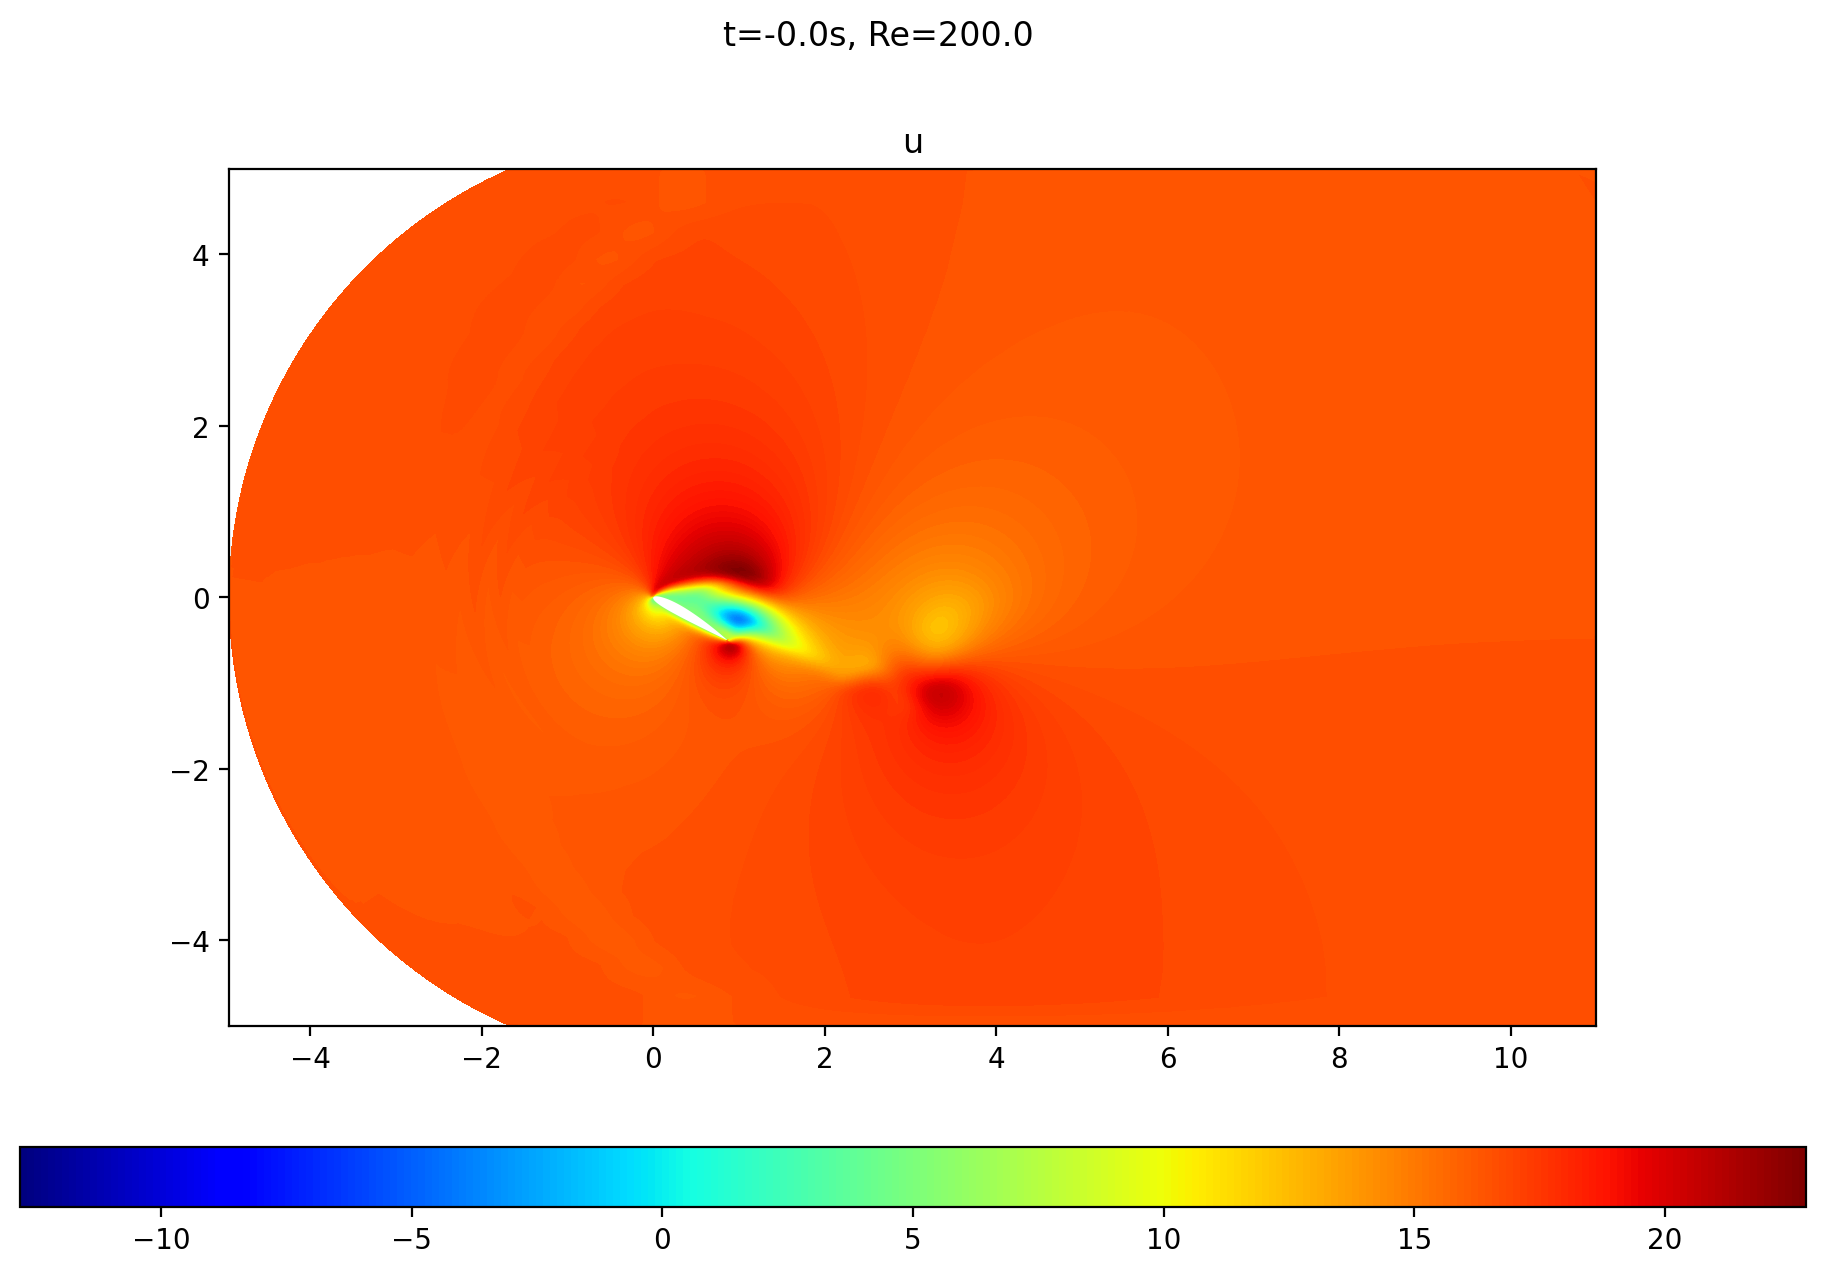

In [ ]:
%%px
from IPython.display import display
from matplotlib.axes import Axes

# airfoil_coords_plot = airfoil_coords[3:, :].tolist()
# airfoil_coords_plot = np.array([airfoil_coords[0]] + airfoil_coords_plot[:68] + [airfoil_coords[1]] + airfoil_coords_plot[68:136] + [airfoil_coords[2]] + airfoil_coords_plot[136:])

if rank==0:


    fields_and_tiles = [
                (u_np, "u"),
                # (v_np, "v"),
                # (p_np, "p")
                ]
    sm_list = [sm_u, sm_v, sm_p]
    norm_list = [norm_u, norm_v, norm_p]

    fig, axs = plt.subplots(1, len(fields_and_tiles))
    # add_zoom(2.4)

    # add_zoom(2.4)

    if isinstance(axs, Axes):
        axs = [axs]

    # plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
    zoom = (len(axs) * 0.5 + 1) * 1.2
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom * ((0.85)/len(axs) + 0.015 * len(axs)))
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

    for i, (field, title) in enumerate(fields_and_tiles):
        cbar_i = fig.colorbar(sm_list[i], ax=axs[i], orientation='horizontal', pad = 0.08 + len(axs) * 0.025, aspect = 30)
        axs[i].set_title(title)

    # whichtimes = np.arange(0, ntimes, 10)
    # whichtimes = [ntimes-1]
    whichtimes = [-1]
    for time in whichtimes:

        for i, (field, _) in enumerate(fields_and_tiles):

            cont = axs[i].tricontourf(triang, field[time, :], cmap="jet", levels=200
                                      # , norm=norm_list[i]
                                      )
            axs[i].set_aspect("equal")

        for ax in axs:
            ax.fill(airfoil_coords[:,0], airfoil_coords[:,1], 'white', edgecolor='white', lw=0)
            # ax.set_xlim([-5, 12.5])
            # ax.set_ylim([-5, 5])
            # ax.scatter(coords[:, 0], coords[:, 1], c="k")

        # x_p, y_p = x_le + chord/2, y_le - 0.2 # circa baricentro
        # x_p, y_p = x_le, y_le # le
        # x_p, y_p = x_le + chord, y_le # te per 0 gradi

        # x_p, y_p = 0.9, -0.42 # te per 20 gradi
        # x_p, y_p = 0.862, -0.5 # te per 30 gradi
        # dist = 0.1
        # plt.gca().set_xlim([x_p - dist*chord, x_p + dist*chord])
        # plt.gca().set_ylim([y_p - chord*dist, y_p + dist*chord])

        # plt.gca().set_xlim([-5, 12.5])
        # plt.gca().set_ylim([-5, 5])

        # fig.subplots_adjust(top=2.95, bottom=0)
        fig.suptitle(f"t={(time*save_to_np_every_steps)/timesteps*T:.1f}s, Re={U_max * chord * rho_ / params[1][0]:.1f} ")

        display(fig)
        plt.close(fig)
        clc(wait=True)


[output:0]

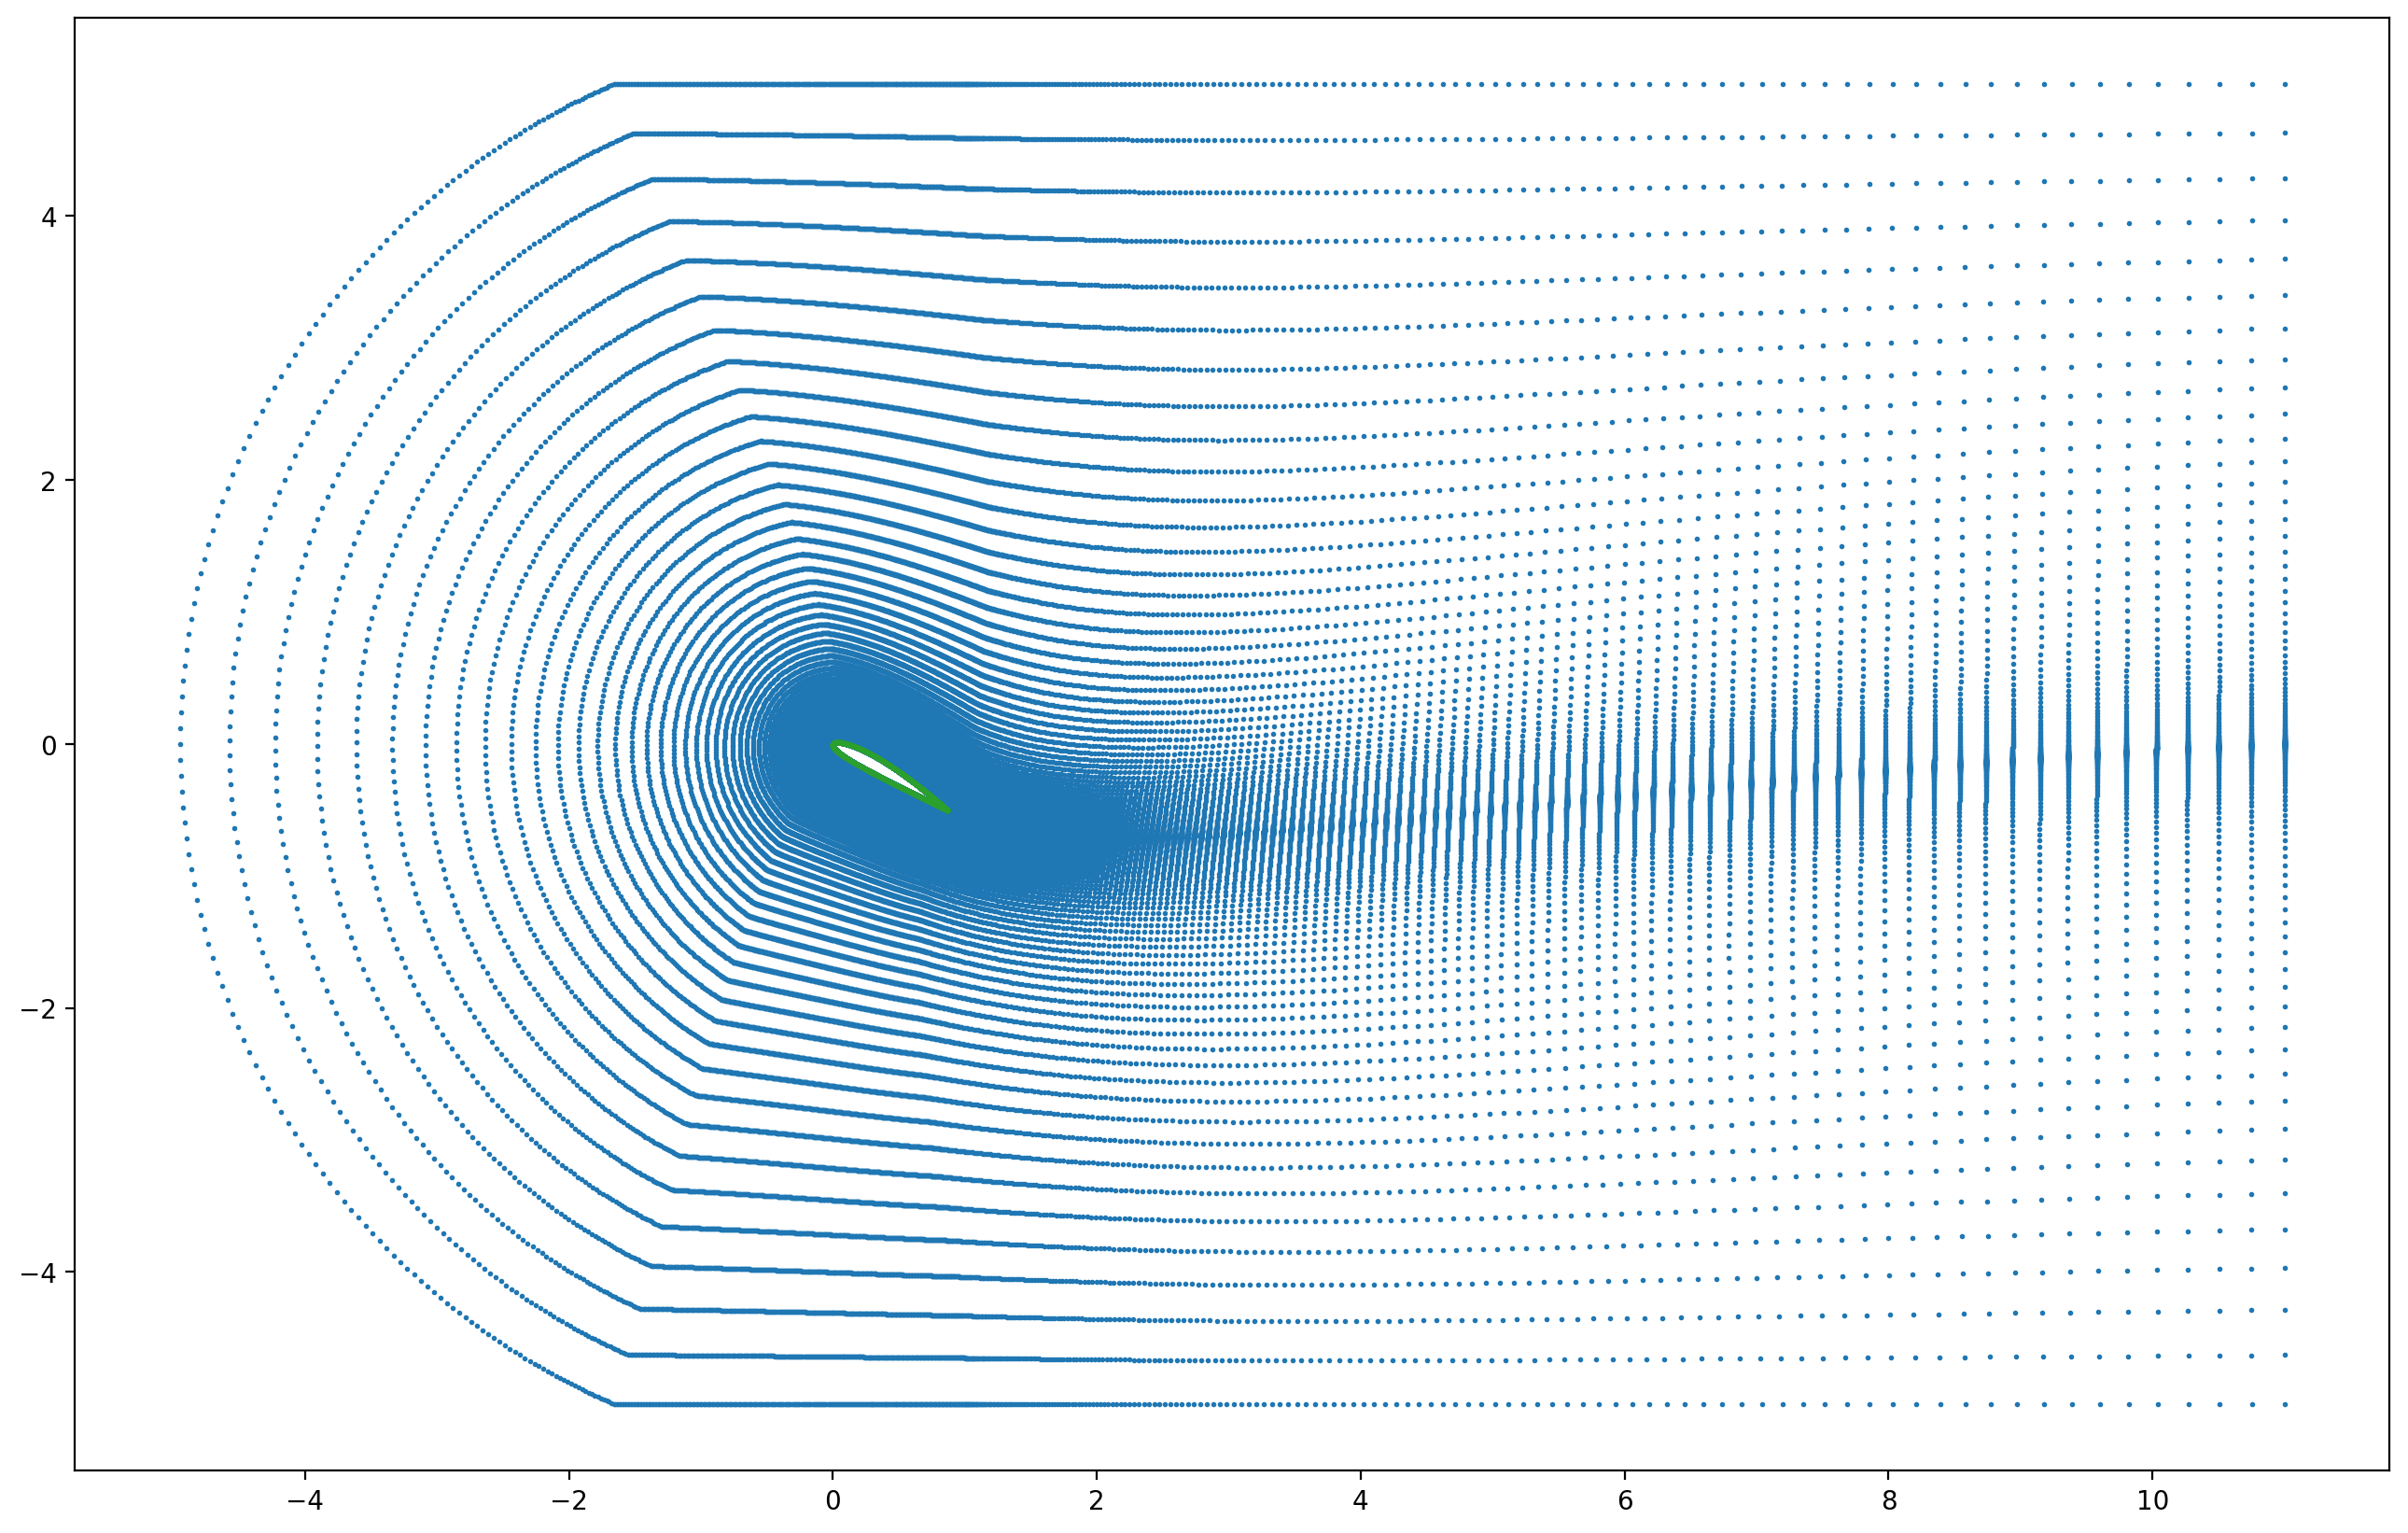

In [ ]:
%%px

# u_np[-1].max()
# np.argmin(u_np[-1])

scatter_array(coords)
scatter_array(coords[np.argmin(u_np[-1])].reshape(1, -1))
scatter_array(airfoil_coords)
add_zoom(2.5)

### gif

In [ ]:
# %%px
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation

# if rank==0:
#     fig, axs = plt.subplots(1, 3)
#     # add_zoom(2.4)

#     # add_zoom(2.4)

#     plt.gcf().set_figheight(plt.gcf().get_figheight() * 0.3)
#     zoom = 2.7
#     plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
#     plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)

#     # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
#     cbar_u = fig.colorbar(sm_u, ax=axs[0], orientation='horizontal', pad = 0.15, aspect = 30)
#     axs[0].set_title("u")
#     cbar_u = fig.colorbar(sm_v, ax=axs[1], orientation='horizontal', pad = 0.15, aspect = 30)
#     axs[1].set_title("v")
#     cbar_p = fig.colorbar(sm_p, ax=axs[2], orientation='horizontal', pad = 0.15, aspect = 30)
#     axs[2].set_title("p")

#     # 2) Funzione di inizializzazione (vuota, serve se usi blit=True)
#     def init():
#         for ax in axs:
#             ax.clear()
#             ax.set_aspect("equal")
#         # ricrea le colorbar se necessario, oppure lasciale fisse come qui
#         return []

#     # Qui mettiamo i contenitori per gli artisti che cambiano
#     last_contours = []
#     last_patches = []

#     def update(frame):
#         # 1) Rimuovi i vecchi TriContourSet
#         for cs in last_contours:
#             cs.remove()
#         last_contours.clear()

#         # 2) Rimuovi le patch dei cilindri
#         for patch in last_patches:
#             patch.remove()
#         last_patches.clear()

#         # 3) Ridisegna i contour
#         cs1 = axs[0].tricontourf(
#             triang, u_np[frame, :],
#             cmap="jet", levels=200, norm=norm_u
#         )
#         cs2 = axs[1].tricontourf(
#             triang, v_np[frame, :],
#             cmap="jet", levels=200, norm=norm_v
#         )
#         cs3 = axs[2].tricontourf(
#             triang, p_np[frame, :],
#             cmap="jet", levels=200, norm=norm_p
#         )

#         # memorizza i TriContourSet
#         last_contours.extend([cs1, cs2])

#         # 4) Ridisegna il cilindro, tenendo le patch appena creare in una lista
#         for cyl in cyl_coords:
#             patch = axs[0].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
#             last_patches.append(patch)
#             patch = axs[1].fill(cyl[:,0], cyl[:,1], 'white', edgecolor='white', lw=1.5)[0]
#             last_patches.append(patch)

#         # 5) Aggiorna il titolo
#         t_val = frame / timesteps * T
#         Re = U_max * np.cos(params[0][0]) * 2 * R * rho_ / params[1][0]
#         fig.suptitle(f"t={t_val:.2f}s, Re={Re:.1f}")

#         # Ritorniamo i due TriContourSet (basta loro, matplotlib sa rinfrescare i patch)
#         return last_contours

#     # Costruiamo l'animazione
#     n_frames = ntimes
#     ani = FuncAnimation(
#         fig, update, frames=range(n_frames),
#         blit=True, interval=100
#     )

#     # # Per vederla in Jupyter:
#     # from IPython.display import HTML
#     # HTML(ani.to_jshtml())

#     # Oppure per salvarla:
#     ani.save("animazione.mp4", writer="ffmpeg", fps=10)

### get boundary nodes

In [ ]:
%%px
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
Q_vec = functionspace(mesh, s_cg1)

In [ ]:
%%px
MPI.COMM_WORLD.size


Out[0:414]: 1

In [ ]:
%%px
def get_boundary_idxs(mesh, ft, marker):
    boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
    vertices = dolfinx.mesh.compute_incident_entities(mesh.topology, ft.find(marker), mesh.topology.dim-1, 0)
    idxs = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, vertices, False)

    return idxs[:, 0].tolist()

[output:0]

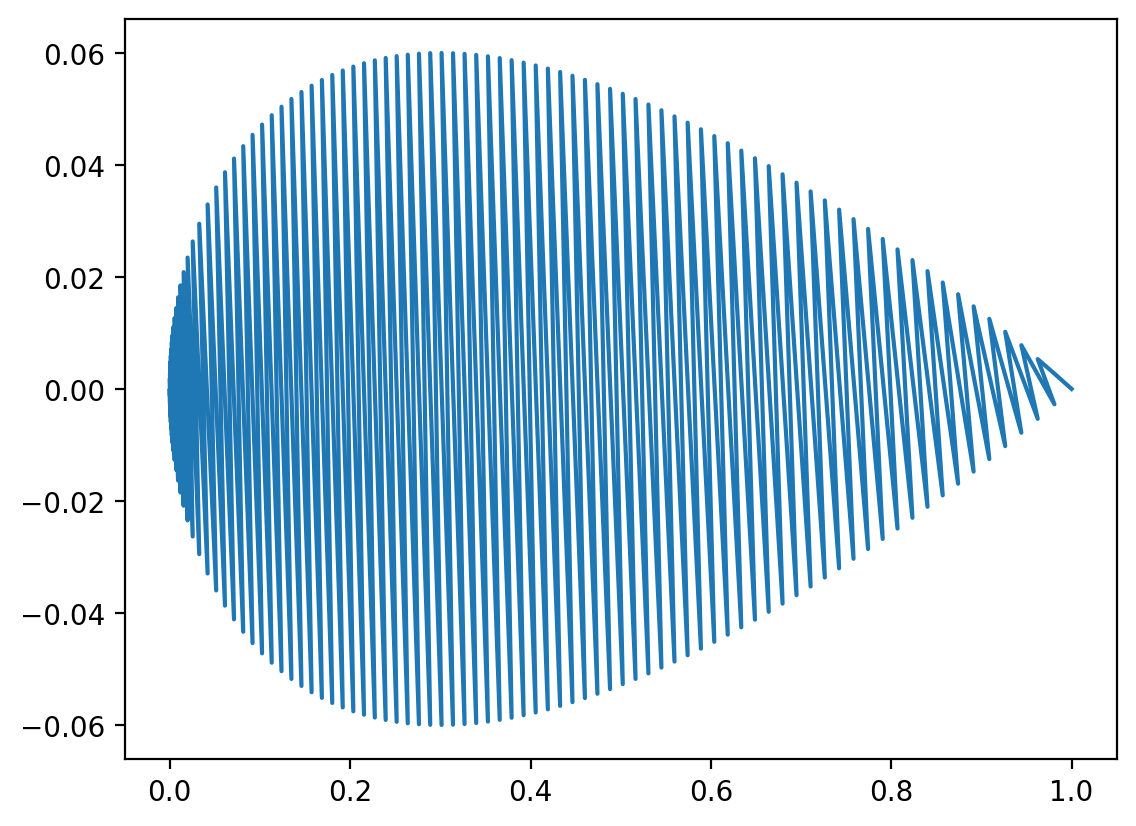

In [ ]:
%%px
# len(coords)
unordered_polygon = coords[get_boundary_idxs(mesh, ft, obstacle_marker)]
plt.plot(unordered_polygon[:, 0], unordered_polygon[:, 1])
plt.show()

[output:0]

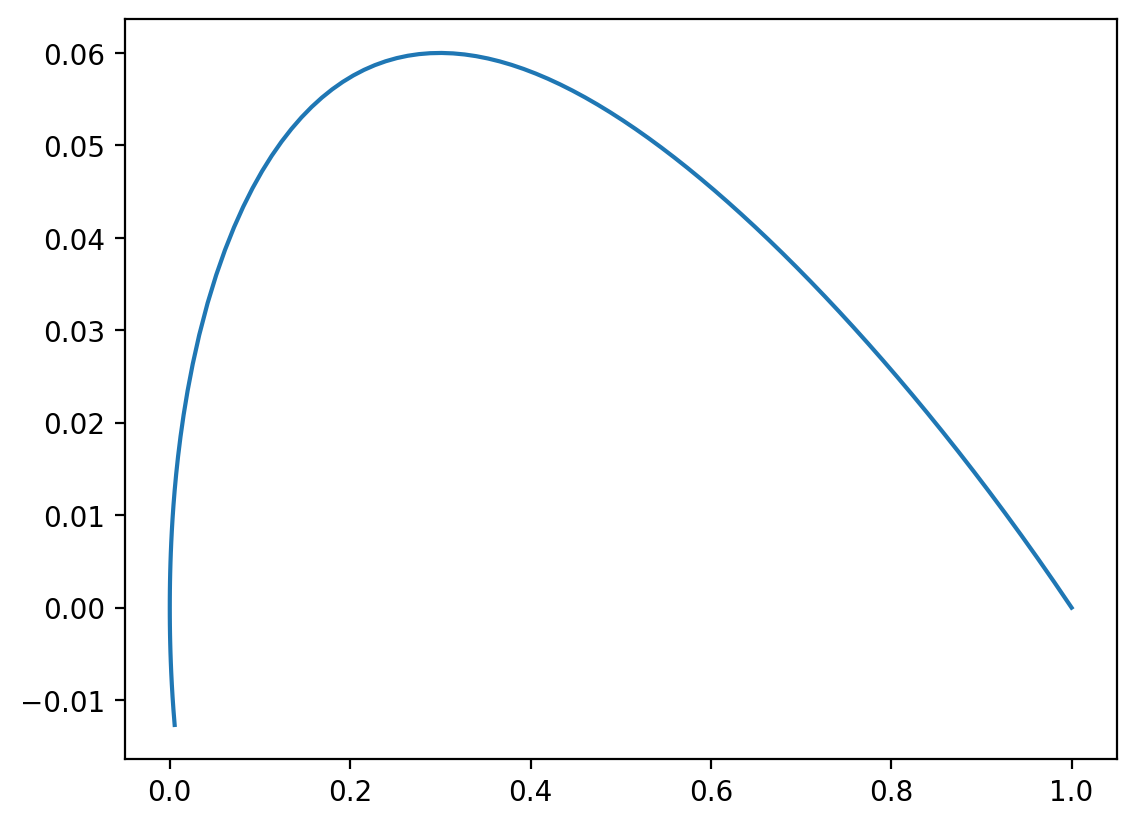

In [ ]:
%%px
ordered_polygon = order_polygon(unordered_polygon)
plt.plot(ordered_polygon[:100, 0], ordered_polygon[:100, 1])
plt.show()

In [ ]:
%%px
biggest_x_idx = np.argmax(ordered_polygon)
new_polygon = np.concatenate([ordered_polygon[biggest_x_idx:], ordered_polygon[:biggest_x_idx]])

In [ ]:
%%px
xy_points = unordered_polygon
# Compute the centroid (average of all points)
centroid = np.mean(xy_points, axis=0)

# Compute angles relative to centroid
angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])
angles

### test_smoothing

In [ ]:
%%px

# Scrive un unico file .xdmf (supportato in ParaView)
with XDMFFile(mesh.comm, "mesh_2412_30deg_final.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)

[output:0]

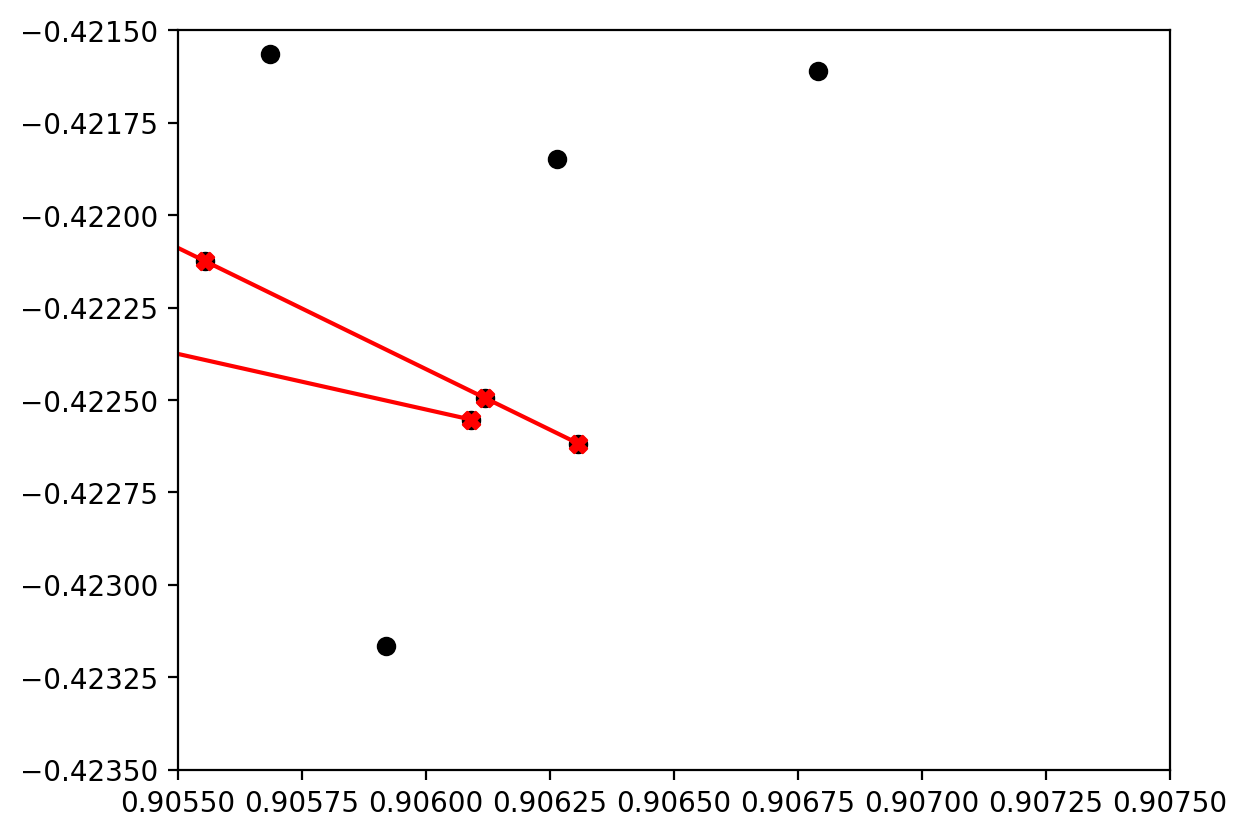

In [ ]:
%%px

new_control_points = control_points+displacements
plt.scatter(coords[:, 0], coords[:, 1], c="k")
plt.plot(new_control_points[:N_points, 0], new_control_points[:N_points, 1], c="r")
plt.scatter(new_control_points[:N_points, 0], new_control_points[:N_points, 1], marker="X", c="r")
x_p, y_p = 0.9065, -0.4225
dist = 0.001
plt.gca().set_xlim([x_p - dist*chord, x_p + dist*chord])
plt.gca().set_ylim([y_p - chord*dist, y_p + dist*chord])
plt.show()


In [ ]:
%%px
def smooth_mesh_dolfinx(mesh, iterations=10, omega=0.3, fix_boundary=True):
    """
    Applica Laplacian smoothing alla mesh DolfinX in-place.

    Parametri:
        mesh         : dolfinx.mesh.Mesh
        iterations   : numero di passi di smoothing
        omega        : fattore di rilassamento (0<omega<1)
        fix_boundary : se True, i nodi su facce esterne non vengono mossi
    """
    # Copia delle coordinate
    coords = mesh.geometry.x.copy()

    # Topologia necessaria
    topo = mesh.topology
    topo.create_connectivity(0, topo.dim)
    topo.create_connectivity(topo.dim, 0)

    # Connessioni vertice->cella e cella->vertice
    v2c = topo.connectivity(0, topo.dim)
    c2v = topo.connectivity(topo.dim, 0)

    # Calcola facce di bordo e vertici di bordo
    boundary_vertices = set()
    if fix_boundary:
        # Crea connettività faccia->vertice
        topo.create_connectivity(topo.dim - 1, 0)
        # Indici delle facet esterne
        boundary_facets = dolfinx.mesh.exterior_facet_indices(topo)
        # Vertici incidenti a queste facet
        bv = dolfinx.mesh.compute_incident_entities(topo, boundary_facets, topo.dim - 1, 0)
        # Mappa C++ -> geometria (necessario per assicurare ordinamento corretto)
        vertex_to_geometry = dolfinx.cpp.mesh.entities_to_geometry(mesh._cpp_object, 0, bv, False)
        boundary_vertices = set(bv)

    # Loop di smoothing
    for _ in range(iterations):
        new_coords = coords.copy()
        for vid in range(coords.shape[0]):
            if vid in boundary_vertices:
                continue
            # celle attorno al vertice
            cell_ids = v2c.links(vid)
            # insieme vertici vicini
            neigh_vs = set()
            for cid in cell_ids:
                neigh_vs.update(c2v.links(cid))
            neigh_vs.discard(vid)
            if not neigh_vs:
                continue
            # baricentro
            centroid = coords[list(neigh_vs)].mean(axis=0)
            # spostamento
            new_coords[vid] += omega * (centroid - coords[vid])
        coords = new_coords

    # Scrivi nuove coordinate
    mesh.geometry.x[:] = coords
    return mesh

In [ ]:
%%px
mesh = smooth_mesh_dolfinx(mesh, iterations=10, omega=0.3, fix_boundary=True)

In [ ]:
%%px

# Scrive un unico file .xdmf (supportato in ParaView)
with XDMFFile(mesh.comm, "mesh_smoothata.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)